In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# from xgboost import XGBRegressor, plot_tree
# import xgboost as xgb
# import lightgbm as lgb

# = = = = = =
# own stuff
# = = = = = =
cwd = os.getcwd()
os.chdir("../")
import data_prepro as data_prepro
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [11]:
from importlib import reload
reload(data_prepro)

<module 'data_prepro' from '/Users/yanting/Desktop/2023_11-PTSFC/data_prepro.py'>

In [12]:
df_energy = data_prepro.get_energy_data_today(to_date="20240103")
print(df_energy.info())
df_energy.tail(5)

/Users/yanting/Desktop/2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78960 entries, 2014-12-31 23:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78960 non-null  datetime64[ns, CET]
 1   gesamt         78960 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-03 18:00:00+00:00,2024-01-03 19:00:00+01:00,60805.75
2024-01-03 19:00:00+00:00,2024-01-03 20:00:00+01:00,56991.25
2024-01-03 20:00:00+00:00,2024-01-03 21:00:00+01:00,54311.00
2024-01-03 21:00:00+00:00,2024-01-03 22:00:00+01:00,51735.00
2024-01-03 22:00:00+00:00,2024-01-03 23:00:00+01:00,48203.00


In [13]:
import os as os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

### Data Split

In [14]:
df_energy_dummy = data_prepro.create_dummy_df(df_energy, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = data_prepro.create_features_df(df_energy, holiday_method='separate', lags=[24, 7*24])

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2020-01-01'
end     = '2024-01-01'
df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > start) & 
                                            (df_energy_dummy['timestamp_CET'] <= end)]
df_energy_fturs_small = df_energy_fturs.loc[(df_energy_fturs['timestamp_CET'] > start) & 
                                            (df_energy_fturs['timestamp_CET'] <= end)]

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =                                       
# time series train test split

# use sklearn TimeSeriesSplit to genrate ...
    # X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy
    # X_train_fturs, X_test_fturs, y_train_fturs, y_test_fturs

X = df_energy_fturs_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_fturs_small['gesamt']

tscv = TimeSeriesSplit(n_splits=2, test_size=200)
for train_index, test_index in tscv.split(X):
    X_train_fturs, X_test_fturs = X.iloc[train_index], X.iloc[test_index]
    y_train_fturs, y_test_fturs = y.iloc[train_index], y.iloc[test_index]

X = df_energy_dummy_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_dummy_small['gesamt']

for train_index, test_index in tscv.split(X):
    X_train_dummy, X_test_dummy = X.iloc[train_index], X.iloc[test_index]
    y_train_dummy, y_test_dummy = y.iloc[train_index], y.iloc[test_index]

# [TODO] cross validation

unique years in df: [2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [278]:
# start_date = '2021-12-23'
# end_date = '2021-12-28'

# plt.figure(figsize=(20, 5))
# plt.plot(y_train_fturs.loc[(y_train_fturs.index > start_date) & (y_train_fturs.index < end_date)], label='train')
# plt.legend()
# plt.show()

### Model Train & Fcast

In [6]:
# quant_reg_model = QuantileRegressor(quantile=0.05, alpha=0, solver='highs')
# # alpha is ... Regularization constant that multiplies the L1 penalty term.
# # if alpha is too high ... ie 1 or even 0.5 the coeff are all 0 leading to a constant prediction ...
# # at alpha = 0.1 there are still some constant predictions at extreme quantiles

# quant_reg_fit = quant_reg_model.fit(X_train_dummy, y_train_dummy)

# print(quant_reg_fit.get_params())
# print(quant_reg_fit.intercept_)
# print(quant_reg_fit.coef_)

# # lin_reg_model = LinearRegression()
# # lin_reg_fit = lin_reg_model.fit(X_train_dummy, y_train_dummy)

# # get in sample pred of model
# y_pred_in_sample = quant_reg_fit.predict(X_train_dummy)
# # y_pred_in_sample = lin_reg_fit.predict(X_train_dummy)

# # plot
# plt.figure(figsize=(10, 5))
# plt.plot(y_train_dummy, label='train')
# plt.plot(y_train_dummy.index, y_pred_in_sample, label='in sample fit')
# plt.show()

In [7]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train quantile models ... regression and gradient boosting

# - - - - - - - - - -
# quantile regression with dummies

# !!! IMPORTANT !!!
# check best params ... alpha = ??? 

print('- '*15)  
print(f'> start training quantile regression models ...')
all_models_quant_reg = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')
    quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
    all_models_quant_reg[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

    # print(quantile_regressor.intercept_)
    # df_coef_w_names = pd.DataFrame(quantile_regressor.coef_, index=quantile_regressor.feature_names_in_)
    # print(df_coef_w_names.to_string())

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...


In [8]:
# - - - - - - - - - -
# gradient boosting with features

# !!! IMPORTANT !!! 
# grid search for best params
# for each quantile ???

# common_params = dict(
#     learning_rate=0.3,
#     max_depth=7,
#     min_samples_leaf=5,
#     n_estimators=300, 
#     subsample=0.9
# )
    
quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 400, 'subsample': 0.9}, 
                   0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 250, 'subsample': 0.7},
                   0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.8},
                   0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7, 'n_estimators': 250, 'subsample': 0.7},
                   0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.7}}

# quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7}, 
#                    0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6},
#                    0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6},
#                    0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7},
#                    0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6}}

print('- '*15)  
print(f'> start training gradient boosting models ...')
all_models_grad_boost = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')

    params = quantile_params[alpha]
    # pprint(params)

    # Use the QuantileRegressor for faster training on small to medium datasets n < 10_000
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **params)

    # Use the HistGradientBoostingRegressor for faster training on large datasets n > 10_000
    # gbr = HistGradientBoostingRegressor(loss='quantile', quantile=alpha, **params)

    all_models_grad_boost[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs, y_train_fturs)


- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...


In [9]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# prediction on test set

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_pred = pd.DataFrame(index=y_test_dummy.index)
df_grad_boost_pred = pd.DataFrame(index=y_test_fturs.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    df_quant_reg_pred[name] = quant_reg_model.predict(X_test_dummy)

# Prediction for Gradient Boosting
for name, grad_boost_model in sorted(all_models_grad_boost.items()):
    df_grad_boost_pred[name] = grad_boost_model.predict(X_test_fturs)

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

- - - - - - - - - - - - - - - 
> start prediction ...


In [284]:
# quantile = '0.500'
# print(all_models_quant_reg[f"q {quantile}"].intercept_)
# df_coef_w_names = pd.DataFrame(all_models_quant_reg[f"q {quantile}"].coef_, index=all_models_quant_reg[f"q {quantile}"].feature_names_in_)
# print(df_coef_w_names.to_string())

55414.0
                                     0
month_2                       -540.125
month_3                      -3444.750
month_4                      -6630.375
month_5                      -7910.375
month_6                      -8714.375
month_7                      -8809.250
month_8                      -9798.625
month_9                      -8404.000
month_10                     -5645.250
month_11                     -2793.750
month_12                     -1003.750
weekday_1                     1149.500
weekday_2                     1311.000
weekday_3                     1251.500
weekday_4                      113.375
weekday_5                    -8850.375
weekday_6                   -12133.125
hour_1_summer                -1785.000
hour_2_summer                -2738.125
hour_3_summer                -2632.125
hour_4_summer                -1537.750
hour_5_summer                 1321.875
hour_6_summer                 6842.875
hour_7_summer                11641.500
hour_8_summer    

### Plots

In [10]:
# - - - - - - - - - - 
# simple ensemble average
# df_ensemble_pred = pd.concat((df_quant_reg_pred, df_grad_boost_pred))

# custom weights for each DataFrame
weight_quant_reg = 0.5
weight_grad_boost = 0.5

df_ensemble_pred = (df_quant_reg_pred * weight_quant_reg +
                    df_grad_boost_pred * weight_grad_boost)
df_ensemble_pred = df_ensemble_pred.groupby(df_ensemble_pred.index).mean()

# - - - - - - - - - - 
# special ensemble combination
# df_temp = pd.concat((df_quant_reg_pred, df_grad_boost_pred))
# df_minmax_ens_pred = df_temp.groupby(df_temp.index).agg({'q 0.025': 'min', 
#                                                          'q 0.250': 'min', 
#                                                          'q 0.500': 'mean',
#                                                          'q 0.750': 'max',
#                                                          'q 0.975': 'max'})

df_minmax_ens_pred = df_grad_boost_pred.copy()
# Update 'q 0.025' and 'q 0.975' columns with values from df_quant_reg_pred
df_minmax_ens_pred['q 0.025'] = np.minimum(df_quant_reg_pred['q 0.025'], df_grad_boost_pred['q 0.025'])
df_minmax_ens_pred['q 0.975'] = np.maximum(df_quant_reg_pred['q 0.975'], df_grad_boost_pred['q 0.975'])

def fix_quantile_crossing(df):

    df_out = df.copy()
    for index, row in df.iterrows():

        # check if quantiles are in ascending order
        if not all(row.diff().dropna() > 0):
            # print(f'> ERROR: Quantiles are not in ascending order for {index}')
            # print(row)
            # sort columns 
            df_out.loc[index] = row.sort_values().values
            # print(df_ensemble_pred.loc[index])

    return df_out

df_ensemble_pred = fix_quantile_crossing(df_ensemble_pred)
df_grad_boost_pred = fix_quantile_crossing(df_grad_boost_pred)
df_minmax_ens_pred = fix_quantile_crossing(df_minmax_ens_pred)

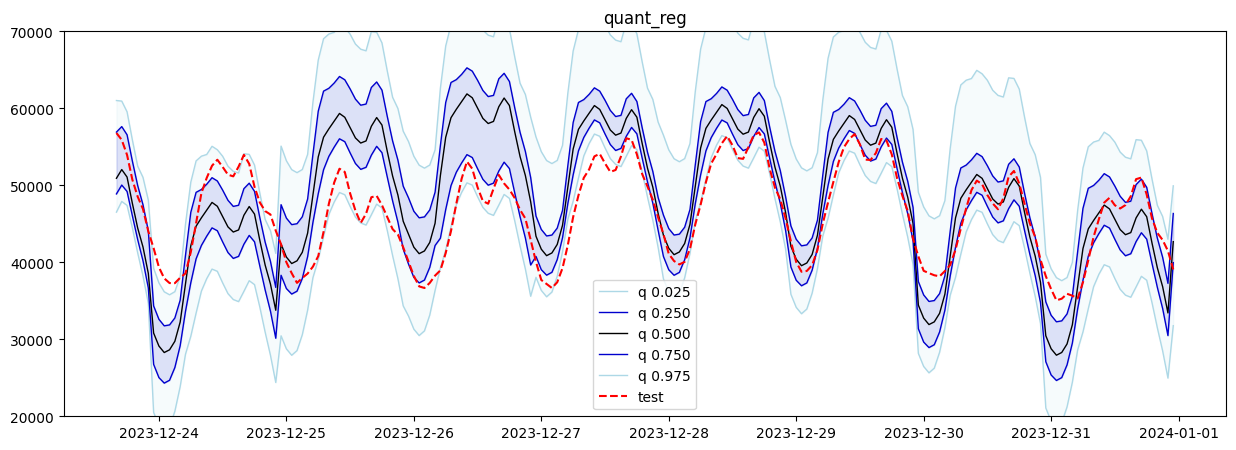

,MSE,MAE,MAPE,pbl=0.025,pbl=0.25,pbl=0.5,pbl=0.75,pbl=0.975
quantile,,,,,,,,
q 0.025,65184295,6040,0.14,305.09,NaN,NaN,NaN,NaN
q 0.250,28979279,4097,0.09,NaN,1669.09,NaN,NaN,NaN
q 0.500,34369583,4887,0.11,NaN,NaN,2443.52,NaN,NaN
q 0.750,59656818,6349,0.14,NaN,NaN,NaN,1889.91,NaN
q 0.975,208955100,12951,0.28,NaN,NaN,NaN,NaN,399.53


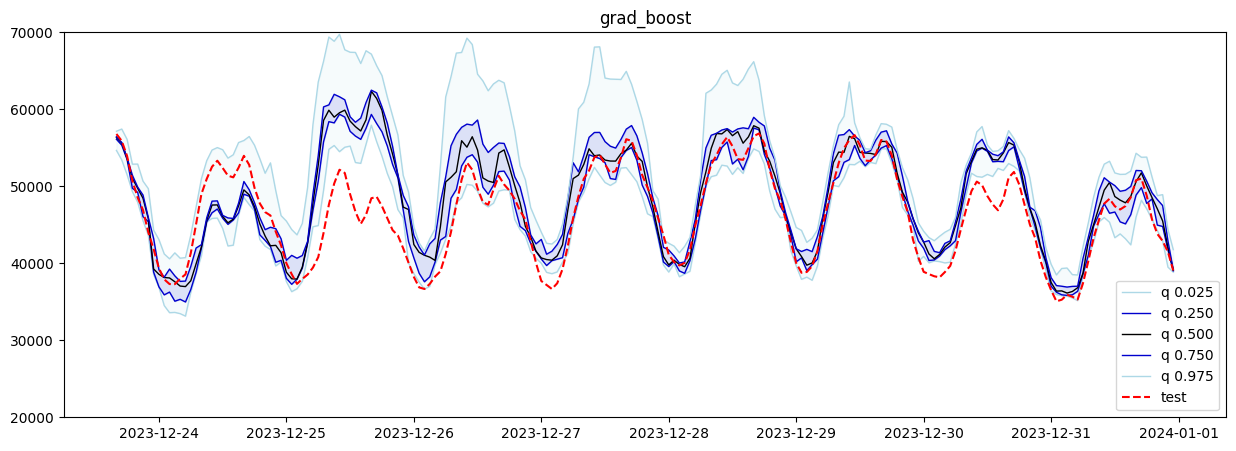

,MSE,MAE,MAPE,pbl=0.025,pbl=0.25,pbl=0.5,pbl=0.75,pbl=0.975
quantile,,,,,,,,
q 0.025,10548960,2488,0.05,877.12,NaN,NaN,NaN,NaN
q 0.250,13235949,2537,0.06,NaN,1455.69,NaN,NaN,NaN
q 0.500,18200858,3016,0.07,NaN,NaN,1507.76,NaN,NaN
q 0.750,25636895,3889,0.09,NaN,NaN,NaN,1136.67,NaN
q 0.975,75991405,7001,0.15,NaN,NaN,NaN,NaN,177.83


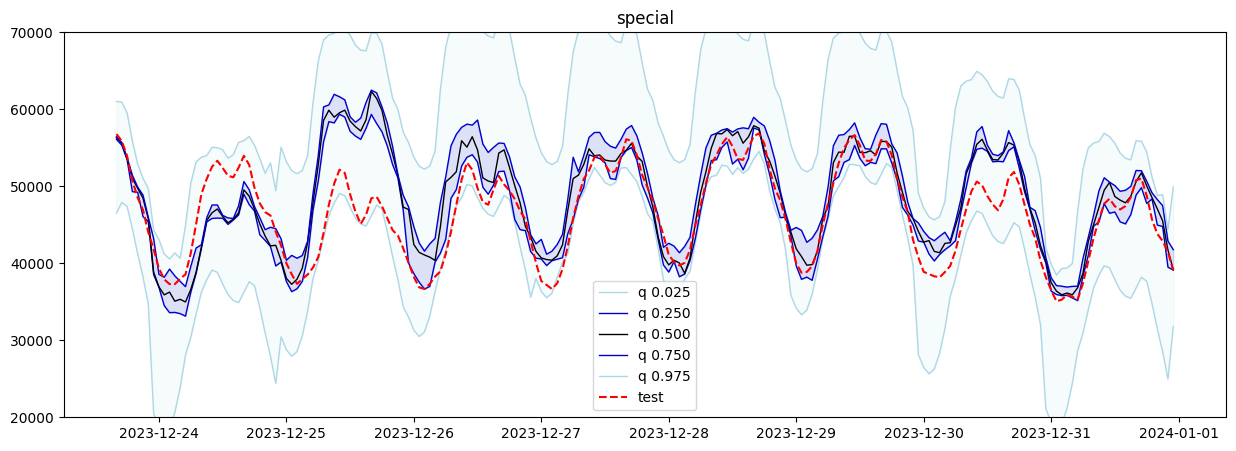

,MSE,MAE,MAPE,pbl=0.025,pbl=0.25,pbl=0.5,pbl=0.75,pbl=0.975
quantile,,,,,,,,
q 0.025,65847612,6202,0.14,168.85,NaN,NaN,NaN,NaN
q 0.250,13821607,2621,0.06,NaN,1421.05,NaN,NaN,NaN
q 0.500,18866189,3118,0.07,NaN,NaN,1559.24,NaN,NaN
q 0.750,27133944,4117,0.09,NaN,NaN,NaN,1201.51,NaN
q 0.975,210647225,13220,0.29,NaN,NaN,NaN,NaN,330.51


In [11]:
df_dict = {'quant_reg': df_quant_reg_pred, 
           'grad_boost': df_grad_boost_pred, 
           # 'ensemble': df_ensemble_pred, 
           'special': df_minmax_ens_pred}

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

# iterate over dict
for model, df in df_dict.items(): 

    plt.figure(figsize=(15, 5))
    plt.title(f'{model}')

    model_errors = []

    for quantile in df.columns:

        y_pred = df[quantile]
        quantile_float = float(quantile[2:])

        metrics = {"quantile": quantile}

        metrics["MSE"] = round(mean_squared_error(y_test_dummy, y_pred))
        metrics["MAE"] = round(mean_absolute_error(y_test_dummy, y_pred))
        metrics["MAPE"] = mean_absolute_percentage_error(y_test_dummy, y_pred)

        # for alpha in quantiles_arr:
        metrics[f"pbl={quantile_float}"] = mean_pinball_loss(y_test_fturs, y_pred, alpha=quantile_float)

        model_errors.append(metrics)

        # Save predicted values based on quantile
        if '0.025' in quantile:
            y_pred_025 = y_pred
            col = 'lightblue'
        elif '0.25' in quantile:
            y_pred_25 = y_pred
            col = 'mediumblue'
        elif '0.5' in quantile:
            y_pred_50 = y_pred
            col = 'black'
        elif '0.75' in quantile:
            y_pred_75 = y_pred
            col = 'mediumblue'
        elif '0.975' in quantile:
            y_pred_975 = y_pred
            col = 'lightblue'
        
        # Plot the prediction line
        plt.plot(y_test_dummy.index, y_pred, label=f'{quantile}', lw=1, alpha=1, color=col)

    plt.fill_between(y_test_dummy.index, y_pred_025, y_pred_975, color='lightblue', alpha=0.1)
    plt.fill_between(y_test_dummy.index, y_pred_25, y_pred_75, color='mediumblue', alpha=0.1)

    plt.plot(y_test_dummy.index, y_test_dummy, 'r--', label='test')
    
    # shift index back by 1 year
    # last_yr_idx = y_test_dummy.index - pd.DateOffset(years=1)
    # plt.plot(y_test_dummy.index, y_train_dummy.loc[last_yr_idx], label='last year')

    plt.ylim(20_000, 70_000)
    plt.legend()
    plt.show()

    df_results = pd.DataFrame(model_errors).set_index("quantile")

    # add last row in dataframe which is the sum of all above values
    # df_results.loc["total"] = df_results.sum()

    # highlight min in column
    # print MSE in scientific notation
    # display(df_results.style.highlight_min(axis=0))

    display(round(df_results, 2))


### => ACTUAL FORECAST !!!

In [194]:
from importlib import reload
reload(data_prepro)

<module 'data_prepro' from 'C:\\Users\\ytl_c\\OneDrive\\Desktop\\23_24 WS (Master)\\VL - PTSFC\\2023_11-PTSFC\\data_prepro.py'>

In [196]:
# ITERATIVE FCAST ... 1/2 day each time ... 6 times = 3 days ahead

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically
t_now = pd.Timestamp.now(tz='CET')
# set time to 00:00
t_now = t_now.replace(hour=0, minute=0, second=0, microsecond=0)
# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday of this week
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()

wednesday = 2024-01-03 00:00:00+01:00
thursday = 2024-01-04 00:00:00+01:00
C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78960 entries, 2014-12-31 23:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78960 non-null  datetime64[ns, CET]
 1   gesamt         78960 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


In [217]:
# take smaller dataset
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(start, end)

df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

# df_fcast_all = pd.DataFrame()

for fcast_iter in range(6):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ensemble_fcast))
        end = df_energy_small.index.max()
        print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')
    print(fcast_timestamp_UTC)

    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET
    # display(df_temp)

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))
    print('- '*15) 
    print(f"> to be forecasted")
    display(df_fcast.iloc[7*24:])
    
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24])
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').iloc[7*24:]

    # display(df_fcast_fturs)
    # display(df_fcast_dummy)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    print('- '*15)    
    print(f'> start prediction ...')

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    df_ensemble_fcast = pd.concat((df_quant_reg_fcast['q 0.500'], df_grad_boost_fcast['q 0.500']), axis=1)
    df_ensemble_fcast['gesamt'] = df_ensemble_fcast.mean(axis=1)
    df_ensemble_fcast['timestamp_CET'] = df_ensemble_fcast.index.tz_convert('CET')
    df_ensemble_fcast = df_ensemble_fcast[['timestamp_CET', 'gesamt']]
    display(df_ensemble_fcast)

    # save fcast to df
    # df_ensemble_pred = (df_quant_reg_pred * 0.5 + df_grad_boost_pred * 0.5)
    # df_ensemble_pred = df_ensemble_pred.groupby(df_ensemble_pred.index).mean()
    # df_fcast_all = pd.concat((df_fcast_all, df_ensemble_pred))


2023-12-27 22:00:00+00:00 2024-01-03 22:00:00+00:00
DatetimeIndex(['2024-01-03 23:00:00+00:00', '2024-01-04 00:00:00+00:00',
               '2024-01-04 01:00:00+00:00', '2024-01-04 02:00:00+00:00',
               '2024-01-04 03:00:00+00:00', '2024-01-04 04:00:00+00:00',
               '2024-01-04 05:00:00+00:00', '2024-01-04 06:00:00+00:00',
               '2024-01-04 07:00:00+00:00', '2024-01-04 08:00:00+00:00',
               '2024-01-04 09:00:00+00:00', '2024-01-04 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> to be forecasted


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,NaN
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,NaN
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,NaN
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,NaN
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,NaN
2024-01-04 04:00:00+00:00,2024-01-04 05:00:00+01:00,NaN
2024-01-04 05:00:00+00:00,2024-01-04 06:00:00+01:00,NaN
2024-01-04 06:00:00+00:00,2024-01-04 07:00:00+01:00,NaN
2024-01-04 07:00:00+00:00,2024-01-04 08:00:00+01:00,NaN
2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+01:00,NaN


unique years in df: [2023 2024]
- - - - - - - - - - - - - - - 
> start prediction ...


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
2024-01-04 04:00:00+00:00,2024-01-04 05:00:00+01:00,52315.209501
2024-01-04 05:00:00+00:00,2024-01-04 06:00:00+01:00,58247.762315
2024-01-04 06:00:00+00:00,2024-01-04 07:00:00+01:00,63121.788597
2024-01-04 07:00:00+00:00,2024-01-04 08:00:00+01:00,65666.800687
2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+01:00,68674.094923


new end timestamp: 2024-01-04 10:00:00+00:00
DatetimeIndex(['2024-01-04 11:00:00+00:00', '2024-01-04 12:00:00+00:00',
               '2024-01-04 13:00:00+00:00', '2024-01-04 14:00:00+00:00',
               '2024-01-04 15:00:00+00:00', '2024-01-04 16:00:00+00:00',
               '2024-01-04 17:00:00+00:00', '2024-01-04 18:00:00+00:00',
               '2024-01-04 19:00:00+00:00', '2024-01-04 20:00:00+00:00',
               '2024-01-04 21:00:00+00:00', '2024-01-04 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> to be forecasted


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
2024-01-04 04:00:00+00:00,2024-01-04 05:00:00+01:00,52315.209501
2024-01-04 05:00:00+00:00,2024-01-04 06:00:00+01:00,58247.762315
2024-01-04 06:00:00+00:00,2024-01-04 07:00:00+01:00,63121.788597
2024-01-04 07:00:00+00:00,2024-01-04 08:00:00+01:00,65666.800687
2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+01:00,68674.094923


unique years in df: [2023 2024]
- - - - - - - - - - - - - - - 
> start prediction ...


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
2024-01-04 04:00:00+00:00,2024-01-04 05:00:00+01:00,52315.209501
2024-01-04 05:00:00+00:00,2024-01-04 06:00:00+01:00,58247.762315
2024-01-04 06:00:00+00:00,2024-01-04 07:00:00+01:00,63121.788597
2024-01-04 07:00:00+00:00,2024-01-04 08:00:00+01:00,65666.800687
2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+01:00,68674.094923


new end timestamp: 2024-01-04 22:00:00+00:00
DatetimeIndex(['2024-01-04 23:00:00+00:00', '2024-01-05 00:00:00+00:00',
               '2024-01-05 01:00:00+00:00', '2024-01-05 02:00:00+00:00',
               '2024-01-05 03:00:00+00:00', '2024-01-05 04:00:00+00:00',
               '2024-01-05 05:00:00+00:00', '2024-01-05 06:00:00+00:00',
               '2024-01-05 07:00:00+00:00', '2024-01-05 08:00:00+00:00',
               '2024-01-05 09:00:00+00:00', '2024-01-05 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> to be forecasted


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
2024-01-04 04:00:00+00:00,2024-01-04 05:00:00+01:00,52315.209501
2024-01-04 05:00:00+00:00,2024-01-04 06:00:00+01:00,58247.762315
2024-01-04 06:00:00+00:00,2024-01-04 07:00:00+01:00,63121.788597
2024-01-04 07:00:00+00:00,2024-01-04 08:00:00+01:00,65666.800687
2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+01:00,68674.094923


unique years in df: [2023 2024]
- - - - - - - - - - - - - - - 
> start prediction ...


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
2024-01-04 04:00:00+00:00,2024-01-04 05:00:00+01:00,52315.209501
2024-01-04 05:00:00+00:00,2024-01-04 06:00:00+01:00,58247.762315
2024-01-04 06:00:00+00:00,2024-01-04 07:00:00+01:00,63121.788597
2024-01-04 07:00:00+00:00,2024-01-04 08:00:00+01:00,65666.800687
2024-01-04 08:00:00+00:00,2024-01-04 09:00:00+01:00,68674.094923


new end timestamp: 2024-01-05 10:00:00+00:00
DatetimeIndex(['2024-01-05 11:00:00+00:00', '2024-01-05 12:00:00+00:00',
               '2024-01-05 13:00:00+00:00', '2024-01-05 14:00:00+00:00',
               '2024-01-05 15:00:00+00:00', '2024-01-05 16:00:00+00:00',
               '2024-01-05 17:00:00+00:00', '2024-01-05 18:00:00+00:00',
               '2024-01-05 19:00:00+00:00', '2024-01-05 20:00:00+00:00',
               '2024-01-05 21:00:00+00:00', '2024-01-05 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> to be forecasted


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
...,...,...
2024-01-05 18:00:00+00:00,2024-01-05 19:00:00+01:00,NaN
2024-01-05 19:00:00+00:00,2024-01-05 20:00:00+01:00,NaN
2024-01-05 20:00:00+00:00,2024-01-05 21:00:00+01:00,NaN
2024-01-05 21:00:00+00:00,2024-01-05 22:00:00+01:00,NaN


unique years in df: [2023 2024]
- - - - - - - - - - - - - - - 
> start prediction ...


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
...,...,...
2024-01-05 18:00:00+00:00,2024-01-05 19:00:00+01:00,69221.204070
2024-01-05 19:00:00+00:00,2024-01-05 20:00:00+01:00,66479.154356
2024-01-05 20:00:00+00:00,2024-01-05 21:00:00+01:00,64344.291418
2024-01-05 21:00:00+00:00,2024-01-05 22:00:00+01:00,62795.368961


new end timestamp: 2024-01-05 22:00:00+00:00
DatetimeIndex(['2024-01-05 23:00:00+00:00', '2024-01-06 00:00:00+00:00',
               '2024-01-06 01:00:00+00:00', '2024-01-06 02:00:00+00:00',
               '2024-01-06 03:00:00+00:00', '2024-01-06 04:00:00+00:00',
               '2024-01-06 05:00:00+00:00', '2024-01-06 06:00:00+00:00',
               '2024-01-06 07:00:00+00:00', '2024-01-06 08:00:00+00:00',
               '2024-01-06 09:00:00+00:00', '2024-01-06 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> to be forecasted


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
...,...,...
2024-01-06 06:00:00+00:00,2024-01-06 07:00:00+01:00,NaN
2024-01-06 07:00:00+00:00,2024-01-06 08:00:00+01:00,NaN
2024-01-06 08:00:00+00:00,2024-01-06 09:00:00+01:00,NaN
2024-01-06 09:00:00+00:00,2024-01-06 10:00:00+01:00,NaN


unique years in df: [2023 2024]
- - - - - - - - - - - - - - - 
> start prediction ...


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
...,...,...
2024-01-06 06:00:00+00:00,2024-01-06 07:00:00+01:00,54703.547146
2024-01-06 07:00:00+00:00,2024-01-06 08:00:00+01:00,57033.581900
2024-01-06 08:00:00+00:00,2024-01-06 09:00:00+01:00,58707.330159
2024-01-06 09:00:00+00:00,2024-01-06 10:00:00+01:00,59773.350869


new end timestamp: 2024-01-06 10:00:00+00:00
DatetimeIndex(['2024-01-06 11:00:00+00:00', '2024-01-06 12:00:00+00:00',
               '2024-01-06 13:00:00+00:00', '2024-01-06 14:00:00+00:00',
               '2024-01-06 15:00:00+00:00', '2024-01-06 16:00:00+00:00',
               '2024-01-06 17:00:00+00:00', '2024-01-06 18:00:00+00:00',
               '2024-01-06 19:00:00+00:00', '2024-01-06 20:00:00+00:00',
               '2024-01-06 21:00:00+00:00', '2024-01-06 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> to be forecasted


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
...,...,...
2024-01-06 18:00:00+00:00,2024-01-06 19:00:00+01:00,NaN
2024-01-06 19:00:00+00:00,2024-01-06 20:00:00+01:00,NaN
2024-01-06 20:00:00+00:00,2024-01-06 21:00:00+01:00,NaN
2024-01-06 21:00:00+00:00,2024-01-06 22:00:00+01:00,NaN


unique years in df: [2023 2024]
- - - - - - - - - - - - - - - 
> start prediction ...


,timestamp_CET,gesamt
2024-01-03 23:00:00+00:00,2024-01-04 00:00:00+01:00,51011.148007
2024-01-04 00:00:00+00:00,2024-01-04 01:00:00+01:00,49074.983468
2024-01-04 01:00:00+00:00,2024-01-04 02:00:00+01:00,48101.635977
2024-01-04 02:00:00+00:00,2024-01-04 03:00:00+01:00,48887.355690
2024-01-04 03:00:00+00:00,2024-01-04 04:00:00+01:00,49755.422987
...,...,...
2024-01-06 18:00:00+00:00,2024-01-06 19:00:00+01:00,59782.650115
2024-01-06 19:00:00+00:00,2024-01-06 20:00:00+01:00,57339.072196
2024-01-06 20:00:00+00:00,2024-01-06 21:00:00+01:00,55484.220443
2024-01-06 21:00:00+00:00,2024-01-06 22:00:00+01:00,53209.547177


In [162]:
# = = = = = = = = = = = = = 
# get data

# = = = = = = = = = = = = = 
# train model on all data

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically
t_now = pd.Timestamp.now(tz='CET')
# set time to 00:00
t_now = t_now.replace(hour=0, minute=0, second=0, microsecond=0)
# get days left till next thursday
days_left = 3 - t_now.dayofweek
# get next thursday
t_next_thursday = t_now + pd.Timedelta(days=days_left)

# - - - - - - - - - - - - - 
# define forecast horizons
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# based on fcast horizons generate timestamps from t0
fcast_idx = []
for fcast in fcast_hor:
    fcast_idx.append(t_next_thursday + pd.Timedelta(hours=fcast))

print(fcast_idx)

# - - - - - - - - - - - - - 
# generate features and dummies

# first turn prediction timestamps into df
df_fcast = pd.DataFrame(fcast_idx, columns=['timestamp_CET'])

# then add features
df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate') # , lags=[24, 7*24])
# then add dummies
df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate')


[Timestamp('2024-01-05 12:00:00+0100', tz='CET'), Timestamp('2024-01-05 16:00:00+0100', tz='CET'), Timestamp('2024-01-05 20:00:00+0100', tz='CET'), Timestamp('2024-01-06 12:00:00+0100', tz='CET'), Timestamp('2024-01-06 16:00:00+0100', tz='CET'), Timestamp('2024-01-06 20:00:00+0100', tz='CET')]


In [167]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# prediction on test set

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_fcast = pd.DataFrame(index=fcast_idx)
df_grad_boost_fcast = pd.DataFrame(index=fcast_idx)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop(['timestamp_CET'], axis=1))
    df_quant_reg_fcast[name] = pred

# # Prediction for Gradient Boosting
# for name, grad_boost_model in sorted(all_models_grad_boost.items()):
#     df_grad_boost_fcast[name] = grad_boost_model.predict(df_fcast_fturs.drop(['timestamp_CET'], axis=1))

np.array(df_quant_reg_fcast/1000)

- - - - - - - - - - - - - - - 
> start prediction ...


array([[61.41275   , 68.3035    , 70.7496875 , 73.106     , 76.58525   ],
       [57.477     , 64.9755    , 67.6776875 , 69.9555    , 73.572     ],
       [56.76075   , 63.70725   , 66.3204375 , 68.3365    , 70.94      ],
       [52.63375   , 55.68725   , 57.30621875, 59.709     , 63.3695    ],
       [48.698     , 52.35925   , 54.23421875, 56.5585    , 60.35625   ],
       [47.98175   , 51.091     , 52.87696875, 54.9395    , 57.72425   ]])

In [165]:
def fix_quantile_crossing(df):

    df_out = df.copy()
    for index, row in df.iterrows():

        # check if quantiles are in ascending order
        if not all(row.diff().dropna() > 0):
            # print(f'> ERROR: Quantiles are not in ascending order for {index}')
            # print(row)
            # sort columns 
            df_out.loc[index] = row.sort_values().values
            # print(df_ensemble_pred.loc[index])

    return df_out

df_quant_reg_fcast = fix_quantile_crossing(df_quant_reg_fcast)